## Second-Quantization Comparison of $H_2$ Molecule

In this work, we prepare two kinds of Second-Quantized Hamiltonian from `PySCF` and Qulacs for comparison. The prepared Hamiltonians are then transfered to JW-Hamiltonians from `openfermion`, and the ground-state energy are calculated by implementing the Hamiltonians into quantum circuits constructed by `Qulacs`. The calculations are done by VQE algorithm, and the quantum circuits are constructed with hardware efficient ansatz shown in [Qulacs](http://docs.qulacs.org/en/latest/apply/6.2_vqe.html). The results are compared with SCF results from `PySCF` and FCI results from `Qulacs`.

First, basic packages are imported.

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
# from openfermion.transforms import get_sparse_operator
from openfermion.linalg import get_sparse_operator
# from openfermion.hamiltonians import MolecularData
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci, lo

from openfermion.ops import InteractionOperator

### Second-quantized Hamiltonian from PySCF
The second-quantized Hamiltonian is acquired from `PySCF`, and the calculation is performed in the quantum circuit constructed by `Qulac`.

The $H_2$ molecule structure is constructed by PySCF with distance = 0.87 Angstrom and orbital basis = 'sto-3g'. There are 2 orbitals, corresponding to 2 qubits in the following quantum calculation.

In [91]:
from pyscf import gto, dft, scf, cc, df, ao2mo

mole_H2 = gto.M(
    atom = '''H  0 0 0; H 0 0 0.87''',
    basis = 'sto-3g', # '6-31g'
    # symmetry = True,
    # charge = 0,
)
H2_ao = mole_H2.ao_labels(); print(H2_ao)
n_qubit = len(H2_ao); print(n_qubit)

['0 H 1s    ', '1 H 1s    ']
2


We first require the SCF energy from SCF calculations provided by `PySCF`. 'mocoeff' is also acquired for mo Hamiltonians.

In [92]:
# import re
mocoeff = mole_H2.RHF().run().mo_coeff
# print(mocoeff)
# E_SCF = re.search(r'=\s*{}')

converged SCF energy = -1.0985065850866


In [93]:
def round2(A, d=1):
    return np.round(A, d)

The one-body ao integrals (kin + nuc) and two-body ao integrals (twobody_ao) are computed and transformed into molecular-orbital values.

In [94]:
kin = mole_H2.intor('int1e_kin')
nuc = mole_H2.intor('int1e_nuc')
# ovlp = mole_H2.intor('int1e_ovlp')
twobody_ao = mole_H2.intor('int2e')

In [95]:
core_ao = kin + nuc
core_mo = np.einsum('pi,pq,qj->ij', mocoeff, core_ao, mocoeff)
twobody_mo = ao2mo.incore.full(twobody_ao, mocoeff)

Jordan-Wigner Hamiltonians are constructed by `openfermion` packages.

In [96]:
mole_H2_Hamiltonian = InteractionOperator(0, core_mo, twobody_mo)
fermionic_hamiltonian = get_fermion_operator(mole_H2_Hamiltonian)
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

In [97]:
print(jw_hamiltonian)

(-0.8606472293353598+0j) [] +
(0.5892227766564004+0j) [Z0] +
(0.2714244526789594+0j) [Z1]


Hardware efficient ansatz quantum circuits and VQE cost functions from [`Qulac`](http://docs.qulacs.org/en/latest/apply/6.2_vqe.html).

In [98]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text

from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

In [99]:
def cost(theta_list):
    state = QuantumState(n_qubit) #Prepare |00000>
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #Construct quantum circuit
    circuit.update_quantum_state(state) #Operate quantum circuit on state
    return qulacs_hamiltonian.get_expectation_value(state) #Calculate expectation value of Hamiltonian

In [100]:
depth = n_qubit

qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))
cost_history_pyscf = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history_pyscf.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 40, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history_pyscf.append(cost(x)))

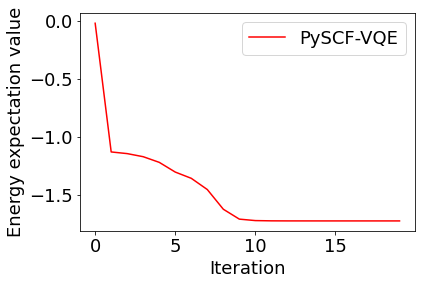

In [101]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history_pyscf, color="red", label="PySCF-VQE")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

### Second-quantized Hamiltonian from Qulac
The second-quantized Hamiltonian is gotten from `Qulac`, and the calculation is performed in the same quantum circuit constructed by `Qulac`.

The $H_2$ molecule structure is constructed by `Qulacs` with same distance(0.87 Angstrom) and same orbital basis('sto-3g'). There are 4 orbitals, corresponding to 4 qubits in the following quantum calculation.

In [102]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.87
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons

print(n_qubit)

4


Get Jordan-Wigner Hamiltonians.

In [103]:
mole_H = molecule.get_molecular_hamiltonian()
fermionic_hamiltonian = get_fermion_operator(mole_H)
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
print(jw_hamiltonian)

(-0.2343583602690013+0j) [] +
(-0.04718928105724672+0j) [X0 X1 Y2 Y3] +
(0.04718928105724672+0j) [X0 Y1 Y2 X3] +
(0.04718928105724672+0j) [Y0 X1 X2 Y3] +
(-0.04718928105724672+0j) [Y0 Y1 X2 X3] +
(0.15293503095916822+0j) [Z0] +
(0.16253371345371698+0j) [Z0 Z1] +
(0.11328237559313416+0j) [Z0 Z2] +
(0.16047165665038088+0j) [Z0 Z3] +
(0.15293503095916822+0j) [Z1] +
(0.16047165665038088+0j) [Z1 Z2] +
(0.11328237559313416+0j) [Z1 Z3] +
(-0.17097423230138864+0j) [Z2] +
(0.1686446527368329+0j) [Z2 Z3] +
(-0.17097423230138864+0j) [Z3]


In [104]:
depth = n_qubit

qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))
cost_history_qulac = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history_qulac.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 40, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history_qulac.append(cost(x)))

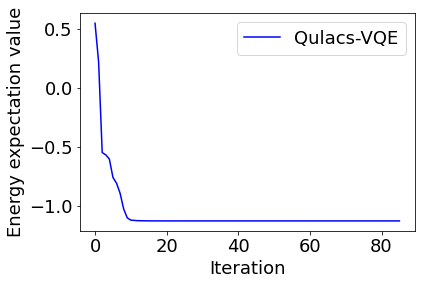

In [105]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history_qulac, color="blue", label="Qulacs-VQE")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

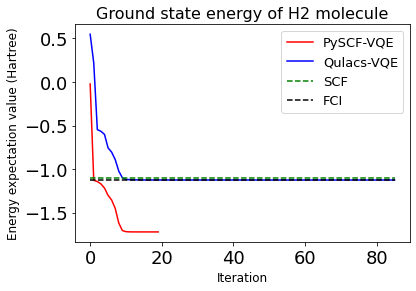

In [106]:
E_SCF = -1.0985
# print(len(cost_history_qulac))
iters = max(len(cost_history_qulac), len(cost_history_pyscf))
plt.rcParams["font.size"] = 18

plt.plot(cost_history_pyscf, color="red", label="PySCF-VQE")
plt.plot(cost_history_qulac, color="blue", label="Qulacs-VQE")
plt.plot(range(iters), [E_SCF]*iters, linestyle="dashed", color="green", label="SCF")
plt.plot(range(iters), [molecule.fci_energy]*iters, linestyle="dashed", color="black", label="FCI")

plt.title("Ground state energy of H2 molecule", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Energy expectation value (Hartree)", fontsize=12)
plt.legend(fontsize=13)
plt.show()

In [107]:
print("E_SCF", E_SCF, 'Hartree')
print("E_FCI", molecule.fci_energy, 'Hartree')
print("E_Qulacs", np.mean(cost_history_qulac[5:]), 'Hartree')
print("E_PySCF", np.mean(cost_history_pyscf[5:]), 'Hartree')

E_SCF -1.0985 Hartree
E_FCI -1.125445863448971 Hartree
E_Qulacs -1.112297970952459 Hartree
E_PySCF -1.6429961181789212 Hartree


From the results above, we notice that the ground state energy from the `PySCF` Hamiltonian is about 0.6 Hartree lower than other results. There might be some parameters missing that leads to this difference.